# Machine Learning Interpretability for Heart Disease Prediction

#### It’s time to get rid of the black boxes and cultivate trust in Machine Learning

Importing necessary libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import explain_prediction
from pdpbox import pdp
import shap 
import lime
import lime.lime_tabular

## Dataset features description
This dataset consists of 13 features and a target variable. The detailed description of all the features are as follows:
1. **Age :** Patients Age in years (Numeric)
2. **Sex :**  Gender of patient [Male - 1, Female - 0] (Nominal)
3. **Chest Pain Type :**  Type of chest pain experienced by patient categorized into [0 typical, 1 typical angina, 2 non- anginal pain, 3 asymptomatic] (Nominal)
 understanding :(https://www.harringtonhospital.org/typical-and-atypical-angina-what-to-look-for/)
4. **resting bps :**  Level of blood pressure at resting mode in mm/HG (Numerical)        
understanding :(https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained#normal) / https://www.hcs.gr/artiriaki-piesi.aspx
5. **cholestrol :**  Serum cholestrol in mg/dl (Numeric)                    
understanding :(https://www.mikroviologos.gr/arthra/cholesterol)
6. **fasting blood sugar :**  Blood sugar levels on fasting > 120 mg/dl represents as 1 in case of true and 0 as false (Nominal)
7. **resting ecg :**  Result of electrocardiogram while at rest are represented in 3 distinct values 0 : Normal 1: Abnormality in ST-T wave 2: Left ventricular hypertrophy (Nominal)
8. **max heart rate :**  Maximum heart rate achieved (Numeric)
9. **exercise angina :**  Angina induced by exercise 0 depicting NO 1 depicting Yes (Nominal)
10. **oldpeak :**  Exercise induced ST-depression in comparison with the state of rest (Numeric)
11. **ST slope :**  ST segment measured in terms of slope during peak exercise [0 = Normal, 1 = Upsloping, 2 = Flat 3: Downsloping ] (Nominal)
12. **ca :** The number of major vessels [0-4]
13. **thal :**  A blood disorder called thalassemia [1 = normal, 2 = fixed defect, 3 = reversable defect]                           
    understanding :( https://bioiatriki.gr/index.php/thalassoaimies)
14. **target :**  Heart disease [0 = no, 1 = yes]

## Exploring & Preparing the data

In [2]:
dt = pd.read_csv('heart.csv')
dt_Shape = {"Total Rows": [len(dt.index)], "Total Columns": [len(dt.columns)]}
dt_Shape = pd.DataFrame(dt_Shape,index=["Values"])
dt_Shape.transpose()

Values
Total Rows        303
Total Columns      14

In [3]:
dt.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

Let's change the column names to be a bit clearer

In [4]:
#Renaming features to proper names
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 
              'rest_ecg', 'max_heart_rate_achieved','exercise_induced_angina', 'st_depression', 'st_slope','major vessels', 
              'thalassemia','target']
dt.head(10)

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   
5   57    1                0                     140          192   
6   56    0                1                     140          294   
7   44    1                1                     120          263   
8   52    1                2                     172          199   
9   57    1                2                     150          168   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    1         0                      150   
1                    0         1                      187   
2                    0         0                      172   
3                    0         1                      178   
4                    0         1                      163   
5                    0         1                      148   
6                    0         0                      153   
7                    0         1                      173   
8                    1         1                      162   
9                    0         1                      174   

   exercise_induced_angina  st_depression  st_slope  major vessels  \
0                        0            2.3         0              0   
1                        0            3.5         0              0   
2                        0            1.4         2              0   
3                        0            0.8         2              0   
4                        1            0.6         2              0   
5                        0            0.4         1              0   
6                        0            1.3         1              0   
7                        0            0.0         2              0   
8                        0            0.5         2              0   
9                        0            1.6         2              0   

   thalassemia  target  
0            1       1  
1            2       1  
2            2       1  
3            2       1  
4            2       1  
5            1       1  
6            2       1  
7            3       1  
8            3       1  
9            2       1

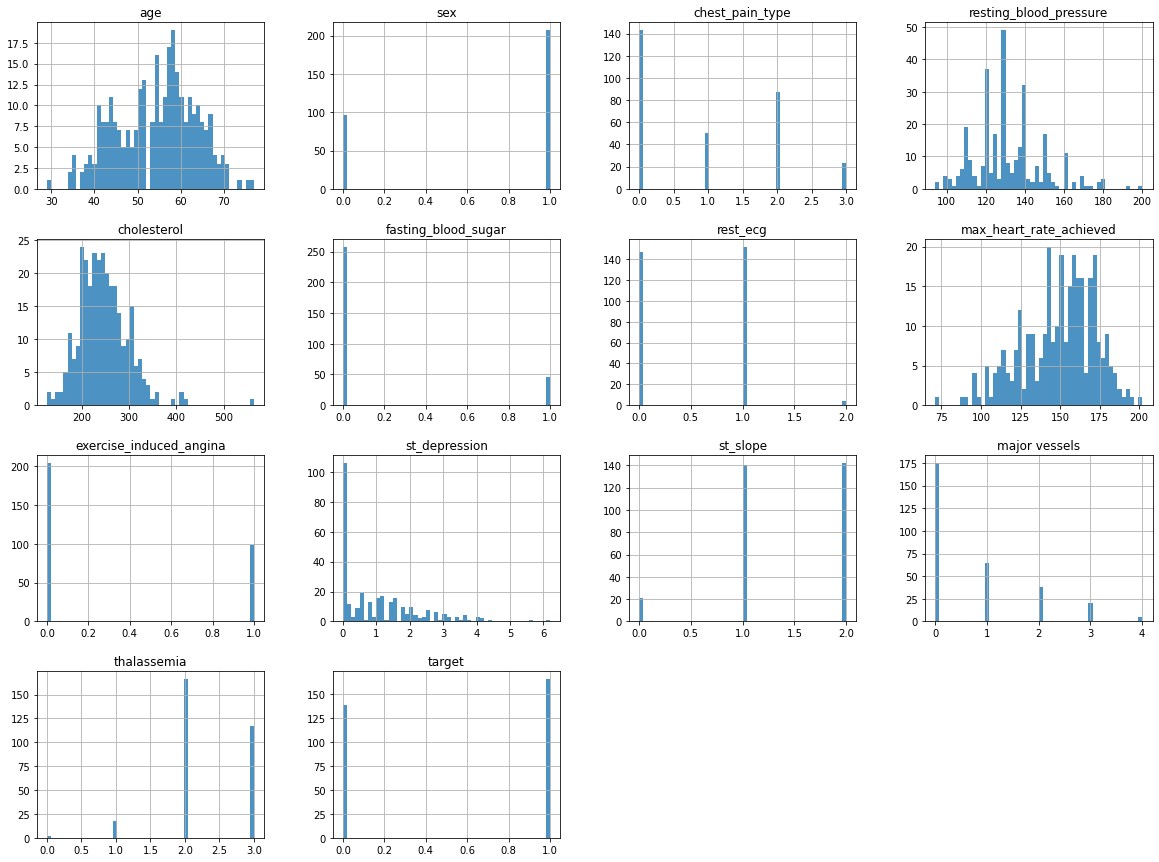

In [5]:
dt.hist(bins=50, figsize = (20,15), alpha = 0.8)
plt.show()

This gives an overview of the distributions of all the features. We can see that the dataset is relatively balanced, i.e. there is a similar number of patients with and without heart disease. 

In [6]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 0] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 0] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 1] = 'flat'
dt['st_slope'][dt['st_slope'] == 2] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
major vessels                int64
thalassemia                 object
target                       int64
dtype: object

In [7]:
dt.shape

(303, 14)

We will scale the numerical data so that each of the features has mean 0 and standard deviation 1. The categorical data will be one hot encoded, and the binary data will be left alone. 

In [8]:
#dropping row with st_slope =0
dt.drop(dt[dt.thalassemia ==0].index, inplace=True)
#checking distribution
dt['thalassemia'].value_counts()

fixed defect         166
reversable defect    117
normal                18
Name: thalassemia, dtype: int64

Encoding categorical variables

In [9]:
# dt = pd.get_dummies(dt, drop_first=True)
dt = pd.get_dummies(dt)
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  major vessels  target  sex_female  sex_male  \
0            2.3              0       1           0         1   
1            3.5              0       1           0         1   
2            1.4              0       1           1         0   
3            0.8              0       1           0         1   
4            0.6              0       1           1         0   

   chest_pain_type_asymptomatic  ...  rest_ecg_left ventricular hypertrophy  \
0                             1  ...                                      0   
1                             0  ...                                      0   
2                             0  ...                                      0   
3                             0  ...                                      0   
4                             0  ...                                      0   

   rest_ecg_normal  exercise_induced_angina_no  exercise_induced_angina_yes  \
0                1                           1                            0   
1                0                           1                            0   
2                1                           1                            0   
3                0                           1                            0   
4                0                           0                            1   

   st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
0                     0              0                   1   
1                     0              0                   1   
2                     1              0                   0   
3                     1              0                   0   
4                     1              0                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0  

[5 rows x 26 columns]

In [10]:
dt.shape

(301, 26)

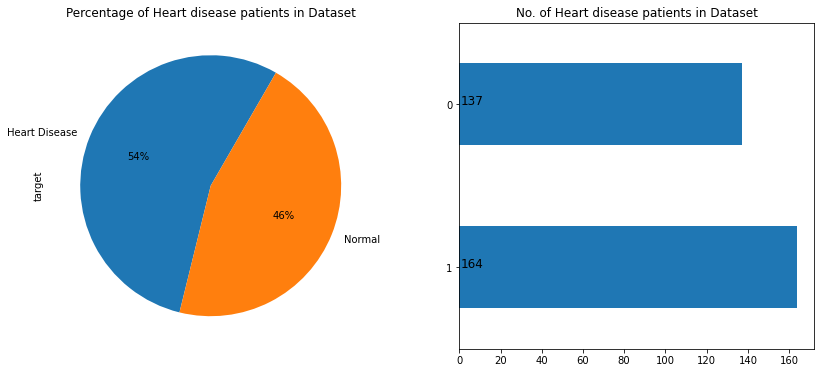

In [11]:
# Distribution of Heart disease (target variable)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))

ax1 = dt['target'].value_counts().plot.pie( x="Heart disease" ,y ='no.of patients', 
                   autopct = "%1.0f%%",labels=["Heart Disease","Normal"], startangle = 60,ax=ax1);
ax1.set(title = 'Percentage of Heart disease patients in Dataset')

ax2 = dt["target"].value_counts().plot(kind="barh" ,ax =ax2)
for i,j in enumerate(dt["target"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title = 'No. of Heart disease patients in Dataset')
plt.show()

In [12]:
countNoDisease = len(dt[dt.target == 0])
countHaveDisease = len(dt[dt.target == 1])
print("Percentage of Patients Haven't Heart Disease: {:.2f}%".format((countNoDisease / (len(dt.target))*100)))
print("Percentage of Patients Have Heart Disease: {:.2f}%".format((countHaveDisease / (len(dt.target))*100)))

Percentage of Patients Haven't Heart Disease: 45.51%
Percentage of Patients Have Heart Disease: 54.49%


In [13]:
dt.groupby('target').mean()

age  resting_blood_pressure  cholesterol  \
target                                                   
0       56.635036              134.445255   251.430657   
1       52.493902              129.310976   242.390244   

        max_heart_rate_achieved  st_depression  major vessels  sex_female  \
target                                                                      
0                    138.978102       1.589781       1.175182    0.175182   
1                    158.731707       0.586585       0.365854    0.432927   

        sex_male  chest_pain_type_asymptomatic  \
target                                           
0       0.824818                      0.051095   
1       0.567073                      0.097561   

        chest_pain_type_atypical angina  ...  \
target                                   ...   
0                              0.065693  ...   
1                              0.250000  ...   

        rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
target                                                           
0                                    0.021898         0.576642   
1                                    0.006098         0.408537   

        exercise_induced_angina_no  exercise_induced_angina_yes  \
target                                                            
0                         0.452555                     0.547445   
1                         0.859756                     0.140244   

        st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
target                                                            
0                   0.255474       0.656934            0.087591   
1                   0.646341       0.298780            0.054878   

        thalassemia_fixed defect  thalassemia_normal  \
target                                                 
0                       0.262774            0.087591   
1                       0.792683            0.036585   

        thalassemia_reversable defect  
target                                 
0                            0.649635  
1                            0.170732  

[2 rows x 25 columns]

In [14]:
X = dt.drop(['target'],axis=1)
y = dt['target']
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)
# checking the shape of dataset
X.shape

(301, 25)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.fit_transform(X_train[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_train.head(10)

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
58   0.111111                0.226415     0.117783                 0.786260   
51   0.822222                0.245283     0.394919                 0.610687   
260  0.822222                0.792453     0.224018                 0.717557   
288  0.622222                0.150943     0.471132                 0.549618   
200  0.333333                0.150943     0.152425                 0.809160   
50   0.488889                0.339623     0.288684                 0.595420   
266  0.577778                0.811321     0.452656                 0.351145   
280  0.288889                0.396226     0.424942                 0.412214   
236  0.644444                0.292453     0.390300                 0.763359   
7    0.333333                0.245283     0.304850                 0.778626   

     st_depression  major vessels  sex_female  sex_male  \
58        0.000000              0           0         1   
51        0.064516              0           0         1   
260       0.161290              2           1         0   
288       0.483871              1           0         1   
200       0.000000              1           0         1   
50        0.080645              0           1         0   
266       0.548387              0           1         0   
280       0.290323              0           0         1   
236       0.000000              2           0         1   
7         0.000000              0           0         1   

     chest_pain_type_asymptomatic  chest_pain_type_atypical angina  ...  \
58                              1                                0  ...   
51                              0                                0  ...   
260                             0                                0  ...   
288                             0                                0  ...   
200                             0                                0  ...   
50                              0                                0  ...   
266                             0                                0  ...   
280                             0                                0  ...   
236                             0                                0  ...   
7                               0                                1  ...   

     rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
58                                       0                1   
51                                       0                1   
260                                      0                0   
288                                      0                0   
200                                      0                1   
50                                       0                1   
266                                      1                0   
280                                      0                0   
236                                      0                1   
7                                        0                0   

     exercise_induced_angina_no  exercise_induced_angina_yes  \
58                            1                            0   
51                            1                            0   
260                           0                            1   
288                           0                            1   
200                           1                            0   
50                            1                            0   
266                           0                            1   
280                           0                            1   
236                           1                            0   
7                             1                            0   

     st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
58                      1              0                   0   
51                      0              1                   0   
260                     0              1                   0   
288      

In [16]:
X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']] = scaler.transform(X_test[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression']])
X_test.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
60   0.933333                0.150943     0.309469                 0.450382   
245  0.422222                0.283019     0.330254                 0.725191   
271  0.711111                0.377358     0.237875                 0.564885   
115  0.177778                0.245283     0.193995                 0.755725   
192  0.555556                0.245283     0.131640                 0.320611   

     st_depression  major vessels  sex_female  sex_male  \
60        0.000000              1           1         0   
245       0.080645              0           0         1   
271       0.419355              2           0         1   
115       0.000000              0           1         0   
192       0.225806              1           0         1   

     chest_pain_type_asymptomatic  chest_pain_type_atypical angina  ...  \
60                              0                                0  ...   
245                             0                                0  ...   
271                             1                                0  ...   
115                             0                                0  ...   
192                             0                                0  ...   

     rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
60                                       0                1   
245                                      0                1   
271                                      0                0   
115                                      0                0   
192                                      0                0   

     exercise_induced_angina_no  exercise_induced_angina_yes  \
60                            1                            0   
245                           1                            0   
271                           1                            0   
115                           1                            0   
192                           1                            0   

     st_slope_downsloping  st_slope_flat  st_slope_upsloping  \
60                      1              0                   0   
245                     0              1                   0   
271                     0              1                   0   
115                     1              0                   0   
192                     0              1                   0   

     thalassemia_fixed defect  thalassemia_normal  \
60                          1                   0   
245                         0                   0   
271                         1                   0   
115                         1                   0   
192                         0                   0   

     thalassemia_reversable defect  
60                               0  
245                              1  
271                              0  
115                              0  
192                              1  

[5 rows x 25 columns]

## Training the models
Here we will train a random forest and logistic regression model.

Logistic regression is a readily interpretable model which allows us to determine the linear relationship between the features and the target. A random forest is a 'black box' model, which will require a little more work to interpret, but which will allow us to view the non-linear relationships between the features and the model predictions.


In [17]:
logit = LogisticRegression(random_state = 0)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
roc=roc_auc_score(y_test, y_pred)
accuracies = cross_val_score(estimator = logit, X = X_test, y = y_test, cv = 10)
acc = accuracies.mean()
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
results = pd.DataFrame([['Base - Logistic Regression', acc,prec,rec, f1,roc]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results

Model  Accuracy  Precision    Recall  F1 Score  \
0  Base - Logistic Regression  0.802381   0.878788  0.878788  0.878788   

        ROC  
0  0.867965

In [18]:
# random_forest = RandomForestClassifier(n_estimators=500,criterion='entropy',max_depth=5).fit(X_train, y_train)
# random_forest = RandomForestClassifier().fit(X_train, y_train)
random_forest = RandomForestClassifier(max_depth=5).fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Model evaluation
roc=roc_auc_score(y_test, y_pred)
accuracies = cross_val_score(estimator = random_forest, X = X_test, y = y_test, cv = 10)
acc = accuracies.mean()
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results = results.append(model_results,sort=True)
results

Accuracy  F1 Score                       Model  Precision       ROC  \
0  0.802381  0.878788  Base - Logistic Regression   0.878788  0.867965   
0  0.788095  0.865672               Random Forest   0.852941  0.850108   

     Recall  
0  0.878788  
0  0.878788

## Feature Importance

### Native methods 
global importance measures. i.e they answer the question 'On average, how important is feature  i  for making a prediction'.

 Both random forests and logistic regression have native methods of formulating the relative importance of features.

 * Decision trees come with a method for measuring the importance of a feature which works by adding up the total decrease 
 in the gini coefficient from nodes that depend on that feature. For a random forest, we can average this value across 
 all trees to get an estimate of festure importance. This is called the mean decrease in gini.

 * For logistic regression, the importances of a feature is just given by the absolute value of its weight. Note that this is 
 only true since we have standardised the variables. Of course the weights themselves have a straightforward interpretation 
 in terms of how the associated feature affects the predicted outcome. 

In [19]:
print('Random Forest:')
display(eli5.show_weights(random_forest, feature_names =X_test.columns.tolist()))
print('Logistic Regression:')
display(eli5.show_weights(logit, feature_names =X_test.columns.tolist()))

Random Forest:


Logistic Regression:


Feature Importance Native methods comment : 

#### One thing that both methods have in common is that they examine which features play the biggest role in fitting to the training set, not which features are most useful for generalisation. If we want to know which risk factors are the most impactful on one's chance of developing heart disease, it is really this second kind of feature importance that we want

There are other drawbacks that are specific to each model:

Random forest:
Mean decrease in gini tends to overestimate the importance of continuous and high cardinality categorical data.
It also underestimates the importance of highly correlated features.

Logistic regression:
By its nature, logistic regression can only model linear relationships between the features and target, and this obviously 
limits its ability to demonstrate the importance of features which have a non-linear effect on the target.

The primary advantage of both is that they are trivial to compute once you have fitted the model.

## 1.) Permutation Importance
### What features does a model think are important? Which features might have a greater impact on the model predictions than the others? 

This concept is called feature importance and Permutation Importance is a technique used widely for calculating feature importance. It helps us to see when our model produces counterintuitive results, and it helps to show the others when our model is working as we’d hope.

Permutation Importance works for many scikit-learn estimators. The idea is simple: Randomly permutate or shuffle a single column in the validation dataset leaving all the other columns intact. A feature is considered “important” if the model’s accuracy drops a lot and causes an increase in error. On the other hand, a feature is considered ‘unimportant’ if shuffling its values doesn’t affect the model’s accuracy.

#### Permutation importance is calculated after a model has been fitted !

In [20]:
print('Permutation Importance')
random_forest = RandomForestClassifier().fit(X_train, y_train)
perm = PermutationImportance(random_forest, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist(),top=24)

Permutation Importance


### Interpretation
* ##### The features at the top are most important and at the bottom, the least.
* ##### The number after the ± measures how performance varied from one-reshuffling to the next.
* ##### Some weights are negative. This is because in those cases predictions on the shuffled data were found to be more accurate than the real data.

Here top 5 important features :
* chest_pain_type_typical angina
* thalassemia_reversable defect
* rest_ecg_ST-T wave abnormality
* major vessels
* thalassemia_fixed defect

Next, to explain individual prediction by random forest model there is a method in eli5 library called show_prediction(). The code for model explanation by eli5 is shown below. As shown in the code above we explain the the 10th record of test set having following prediction as shown in below figure.

In [21]:
eli5.show_prediction(random_forest, X_test.iloc[10], feature_names=X_test.columns.tolist(), show_feature_values=True)

##### Interpretations
To make random forest predictions more interpretable, every prediction of the model can be presented as a sum of feature contributions (plus the bias), showing how the features lead to a particular prediction. In above plot, ELI5 does it by showing weights for each feature with their actual value depicting how influential it might have been in contributing to the final prediction decision across all trees.  

In the above individual prediction, the top 3 influential features seems to be, after the bias, 
the major vessels, thalassemia_fixed defect and max_heart_rate_achieved.

* 42th record of test set having following prediction as shown in below figure :

In [22]:
eli5.show_prediction(random_forest, X_test.iloc[42], feature_names=X_test.columns.tolist(), show_feature_values=True)

In the above individual prediction, the top 3 influential features seems to be, after the bias, 
* major vessels
* thalassemia_fixed defect
* chest_pain_type_typical angina

## 2.) Partial Dependence Plots
### How does each feature affect your predictions ?

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model. PDPs show how a feature affects predictions. PDP can show the relationship between the target and the selected features via 1D or 2D plots.

Like permutation importance, partial dependence plots are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way.

A few items are worth pointing out as you interpret this plot
The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
A blue shaded area indicates level of confidence

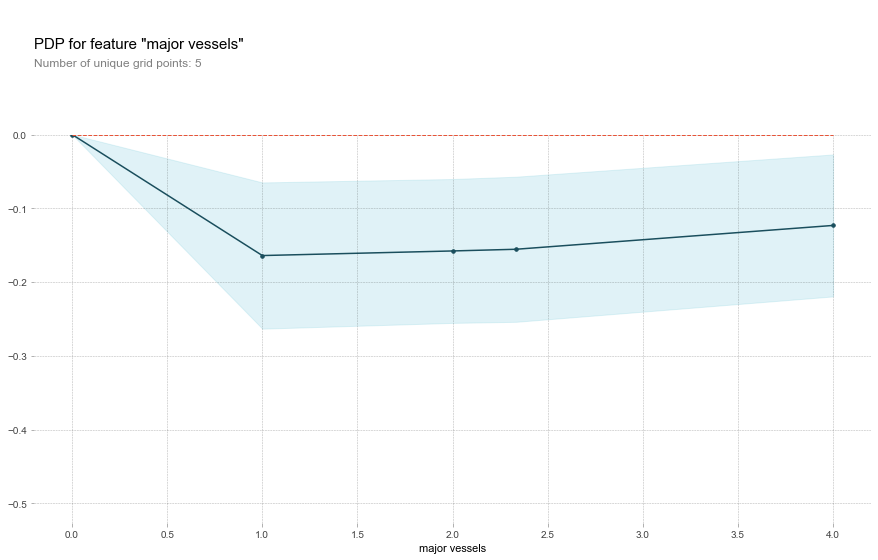

In [23]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'major vessels'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#### So, we can see that as the number of major blood vessels increases, the probability of heart disease decreases. That makes sense, as it means more blood can get to the heart.


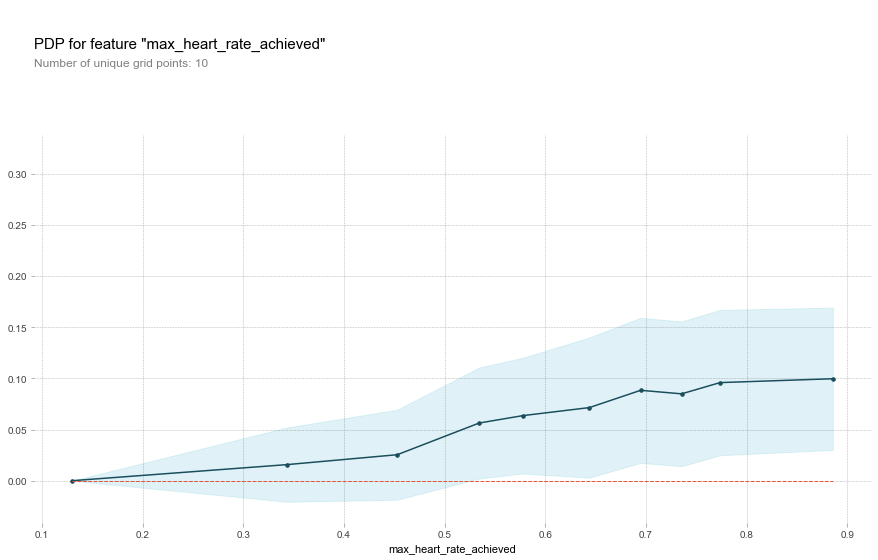

In [24]:
feat_name = 'max_heart_rate_achieved'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#### Here we can see when max_heart_rate_achieved increases, the probability of heart disease increases. That makes sense

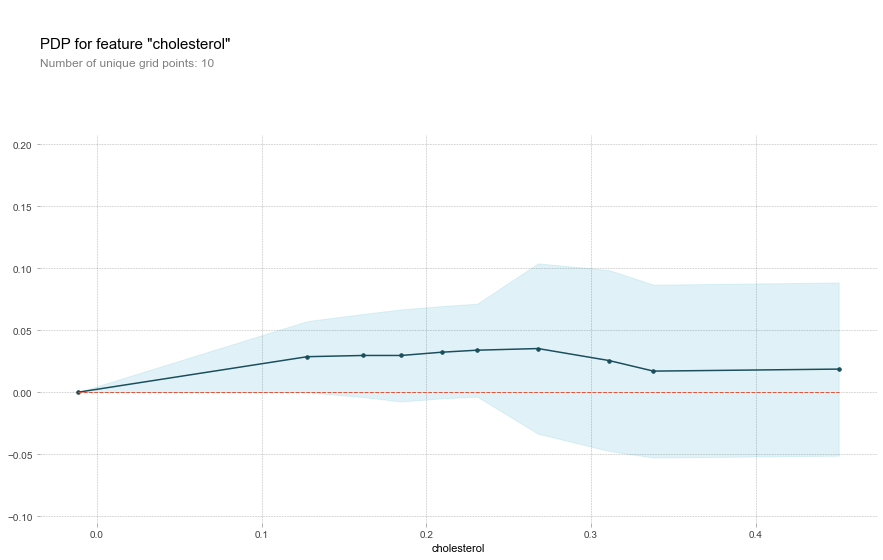

In [25]:
feat_name = 'cholesterol'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

##### we can see when cholesterol increases, the probability of heart disease increases. That makes sense,because high cholesterol increases the risk of cardiovascular disease due to a) an increase in blood pressure and b) the extra load that the heart has to face.

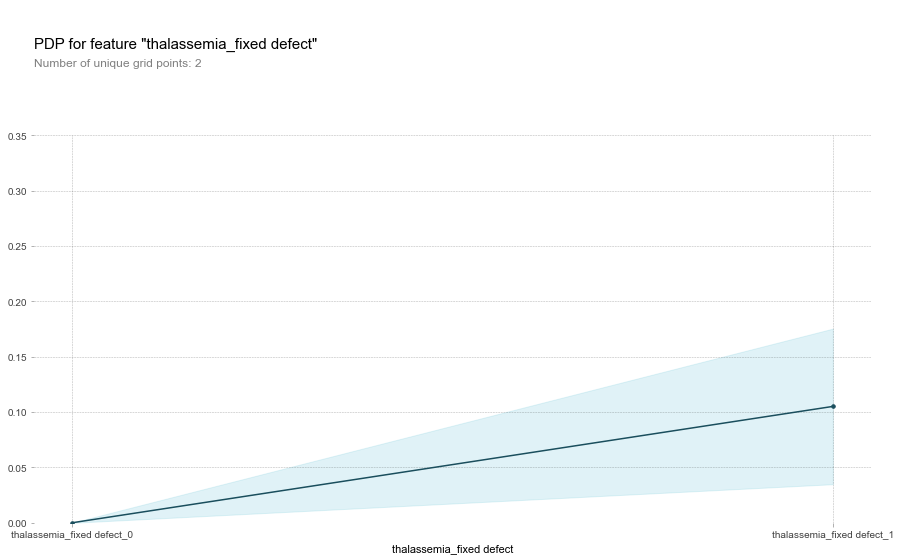

In [26]:
feat_name = 'thalassemia_fixed defect'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#### So, we can see when thalassemia_fixed defect increases, the probability of heart disease increases. That makes sense

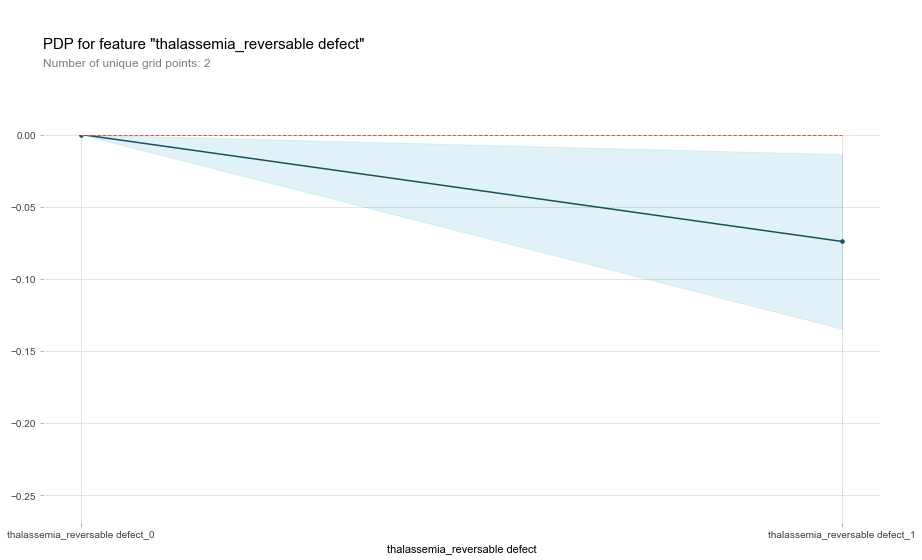

In [27]:
feat_name = 'thalassemia_reversable defect'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#### So, we can see when thalassemia_reversable defect increases, the probability of heart disease decreases. That makes sense

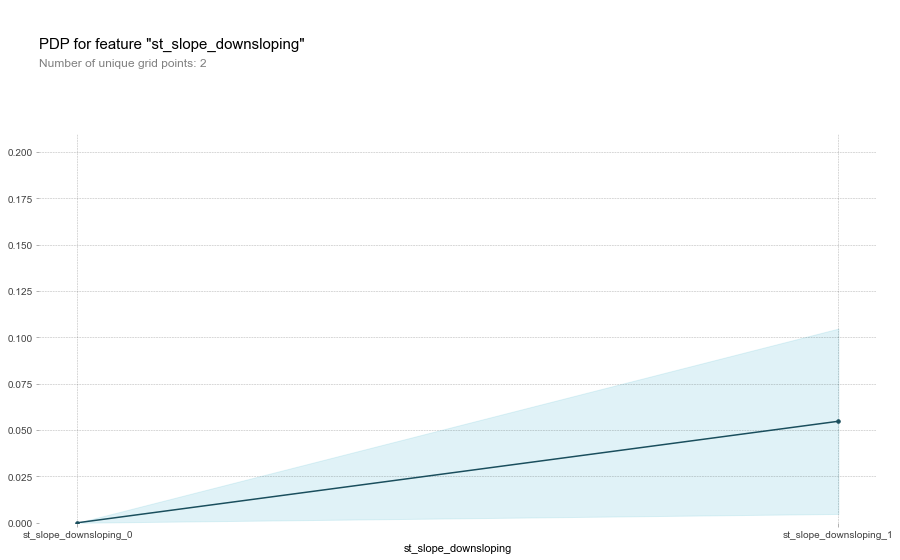

In [28]:
feat_name = 'st_slope_downsloping'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#### So, we can see when st_slope_downsloping increases, the probability of heart disease increases. That makes sense Upward or downward shifts can represent decreased blood flow to the heart from a variety of causes, including heart attack

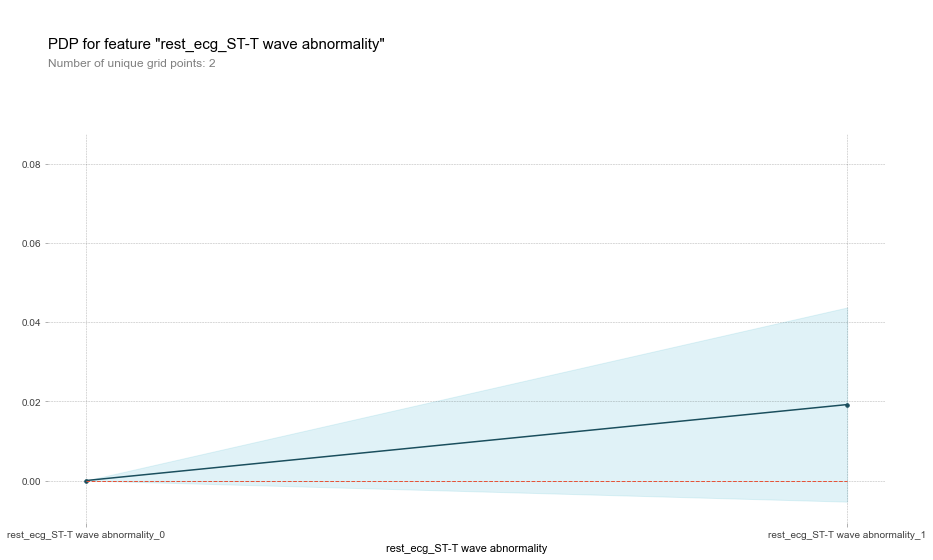

In [29]:
feat_name = 'rest_ecg_ST-T wave abnormality'
pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#### So, we can see when rest_ecg_ST-T wave abnormality increases, the probability of heart disease increases. That makes sense

In [30]:
# All base_features Partial Dependence Plots (PDP):
# base_features = dt.columns.values.tolist()
# base_features.remove('target')
# for feat_name in base_features:
#     pdp_dist = pdp.pdp_isolate(model=random_forest, dataset=X_test, model_features=base_features, feature=feat_name)
#     pdp.pdp_plot(pdp_dist, feat_name)
#     plt.show()

##### ICE plots are similar to PD plots but offer a more detailed view about the behavior of near similar clusters around the  PD plot average curve. ICE algorithm gives the user insight into the several variants of conditional relationships estimated by the black box.

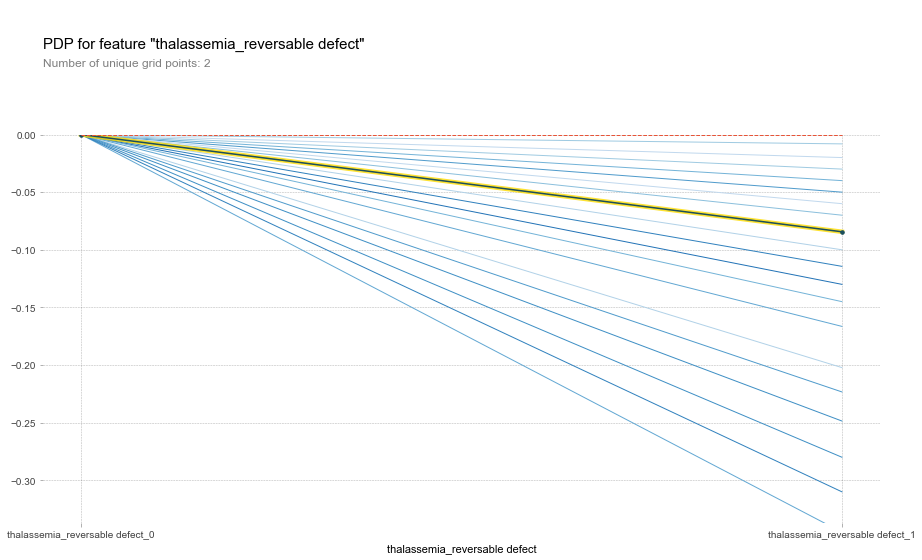

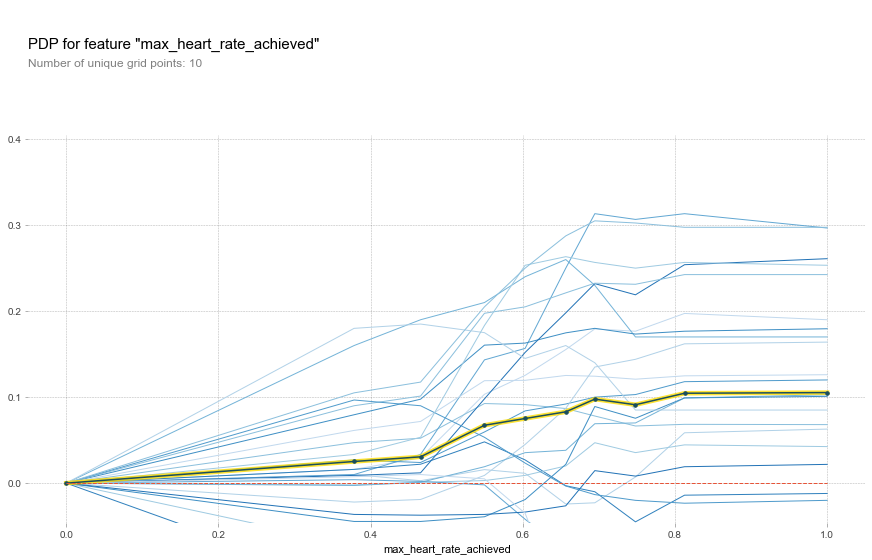

In [31]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()
    
plot_pdp(random_forest, X_train, 'thalassemia_reversable defect', cluster_flag=True, nb_clusters=24, lines_flag=True)
plot_pdp(random_forest, X_train, 'max_heart_rate_achieved', cluster_flag=True, nb_clusters=24, lines_flag=True)

### 2D Partial Dependence Plots
We can also visualize the partial dependence of two features at once using 2D Partial plots.

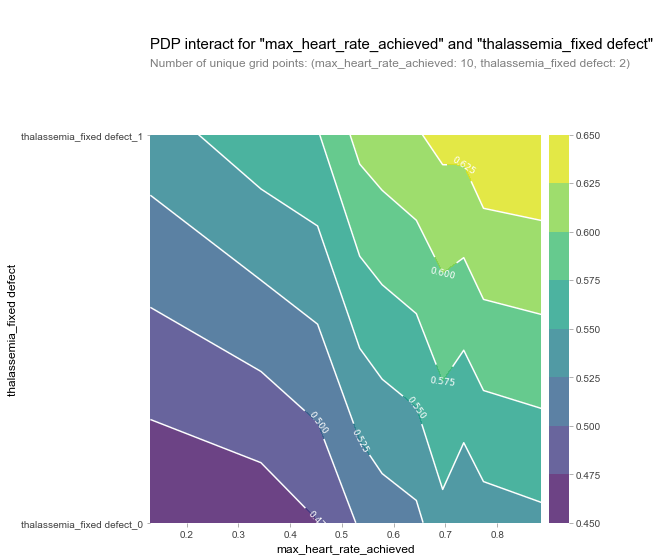

In [32]:
inter1  =  pdp.pdp_interact(model=random_forest, dataset=X_test, model_features=base_features, features=['max_heart_rate_achieved', 'thalassemia_fixed defect'])
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['max_heart_rate_achieved', 'thalassemia_fixed defect'], plot_type='contour')
plt.show()

#### we can see when max_heart_rate_achieved & thalassemia_fixed defect increases, the probability of heart disease increases.

## 3.) SHAP Values
### Understanding individual predictions 

Finally, we will take a look at the Shapley values for different features. Shapley values are an idea that comes from game theory. For an input vector  x , to compute the Shapley value of feature  i , we consider all the possible subset of features that don't include  i , and see how that model prediction would change if we included  i . We then average of all such possible subsets. There are many theoretical properties of Shaply values which make them attractive. In particular, they are the only measure of feature importance which satisfy the following four properties simultaneously (we state these informally).

* Efficiency: The Shapley values of all features for a given prediction sum to the output of the model (i.e. the probability that target = 1).
* Symmetry: Any two features which have the same effect on the prediction are given the same Shapley value.
* Linearity: The Shapley value of a collection of features is the sum of the Shapley values of the features.
* Dummy: A feature which has no effect on the prediction has a Shapley value of 0.

We only compute the shap values for the random forest, and not logistic regression. There are a couple of reasons for this.

* TreeSHAP is a fast algorithm that comutes the exact Shapley values for the features and is unaffected by correlations in the data. For logistic regression we would have to use the KernelSHAP algorithm, which is much slower, is affected by correlations and only provides an approximation of the Shapley values.
* We will want to use Shapley values to plot dependency plots. Since logistic regression is a linear model, we already know that these plots will be linear.

##### Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature). 

The code for plotting Shapley values for individual prediction is shown below.

In [33]:
# use 1 row of data here. Could use multiple rows if desired
row_to_show = 20
data_for_prediction = X_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
random_forest.predict_proba(data_for_prediction_array)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

### Interpretation
The above explanation shows features each contributing to pushing the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue
* The base_value here is 0.453 while our predicted value is 0.97.
* st_depression=0.5484 has the biggest impact on increasing the prediction, while
* major vessels=0 the feature has the biggest effect in decreasing the prediction.

In [34]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 22
data_for_prediction = X_test.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
random_forest.predict_proba(data_for_prediction_array)
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

* major vessels=0, chest_pain_type_typical angina=0 features has the biggest effect in decreasing the prediction.

In [35]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 23
data_for_prediction = X_test.iloc[row_to_show] 
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
random_forest.predict_proba(data_for_prediction_array)
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

In [36]:
# Next, let's pick out individual patients and see how the different variables are affecting their outcomes,
row_to_show = 10
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
random_forest.predict_proba(data_for_prediction_array)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(random_forest)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)


* Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature’s effect. 
* Feature values decreasing the prediction are in blue

### SHAP Feature Importance Plot

The global mean(|Tree SHAP|) method applied to the heart disease prediction model. The x-axis is essentially the average magnitude change in model output when a feature is “hidden” from the model (for this model the output has log-odds units).

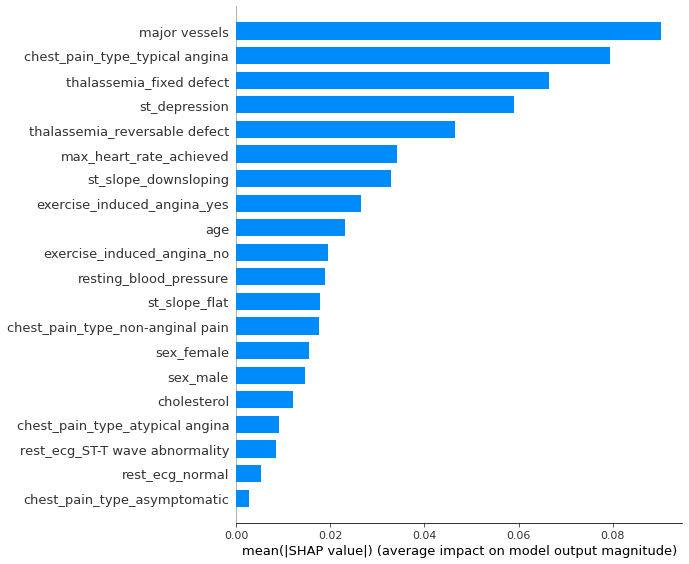

In [37]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

### SHAP Summary Plot

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The summary plot tells which features are most important, and also their range of effects over the dataset.

For every dot:
* Vertical location shows what features it is depicting.
* The color shows whether that feature was high or low for that row of the dataset.
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.

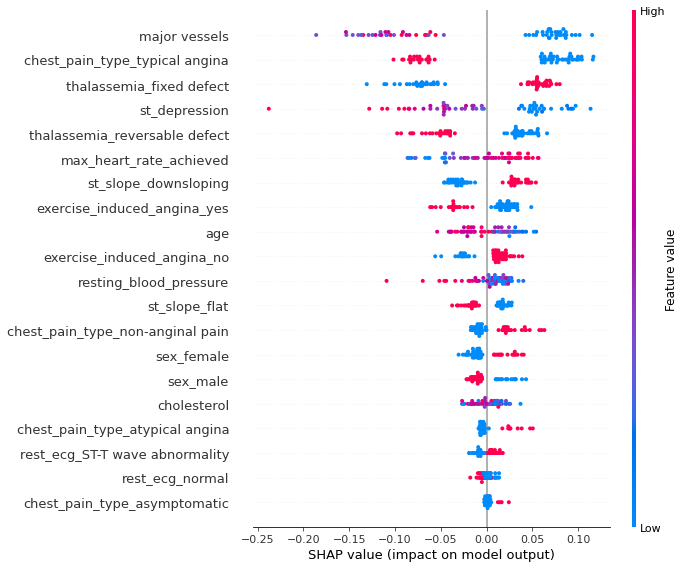

In [38]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

The higher the SHAP value of a feature, 
the higher is the log odds of heart disease in this heart disease prediction model. Every patient in the dataset 
is run through the model and a dot is created for each feature attribution value, so one patient gets one dot on 
each feature’s line. Dot’s are colored by the feature’s value for that patient and pile up vertically to show density

* #### The number of major vessels division is pretty clear, and it's saying that low values are bad (blue on the right), the probability of heart disease increases. 
* #### The number of chest_pain_type_typical angina division is pretty clear, and it's saying that low values are bad (blue on the right). 
* #### Higher values of thalasemia_fixed_defect increases the risk of heart disease whereas its lower values decreases the chances of heart disease.
* #### The thalassemia 'reversable defect' division is very clear (yes = red = good, no = blue = bad).

* #### The thalassemia 'thalassemia_fixed defect' division is very clear (yes = red = bad, no = blue = good).

* #### The thalassemia 'st_slope_upsloping' division is very clear (yes = red = bad, no = blue = good).

In [39]:
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test, feature_names = base_features)

This is an interactive combination of the force plots for each data point. It is currently sorted in such a way that points with similar shap values are clustered together. You can hover over the graph to see the most important features for a given force plot.

## SHAP Dependence Contribution Plots

While a SHAP summary plot gives a general overview of each feature, a SHAP dependence plot shows how the model output varies by a feature value. SHAP dependence contribution plots provide a similar insight to PDPs, but they add a lot more detail.

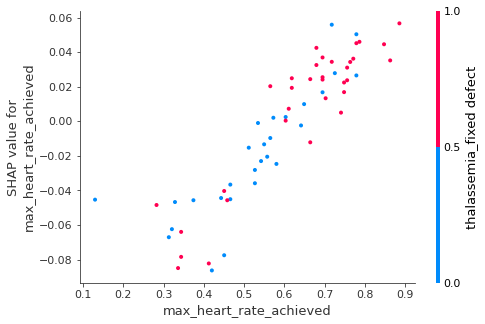

In [40]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('max_heart_rate_achieved', shap_values[1], X_test, interaction_index='thalassemia_fixed defect')

Start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction.
* #### we can see when max_heart_rate_achieved & thalassemia_fixed defect increases, the probability of heart disease increases.

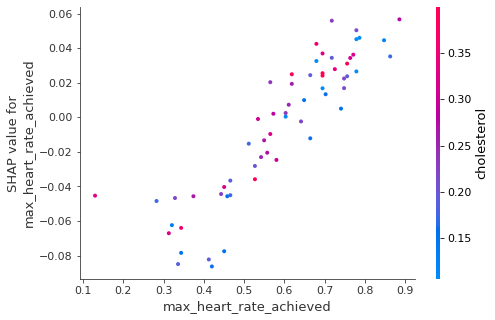

In [41]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('max_heart_rate_achieved', shap_values[1], X_test, interaction_index='cholesterol')

#### 4.) LIME(Local Interpretable Model-agnostic Explanations) --> extra technique 

 Local surrogate models are interpretable models that are used to explain individual 
 predictions of black box machine learning models.
 Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training 
 a global surrogate model, LIME focuses on training local surrogate models to explain individual predictions.

 The recipe for training local surrogate models:

 1.Select your instance of interest for which you want to have an explanation of its black box prediction.
 2.Perturb your dataset and get the black box predictions for these new points.
 3.Weight the new samples according to their proximity to the instance of interest.
 4.Train a weighted, interpretable model on the dataset with the variations.
 5.Explain the prediction by interpreting the local model.
 Interpretable Machine Learning book : https://christophm.github.io/interpretable-ml-book/lime.html

In [42]:
import lime
import lime.lime_tabular
class_names=['Healthy','Disease']
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=base_features, class_names=class_names, discretize_continuous=True)
i = 19
print('Actual Label:', y_test[i])
print('Predicted Label:', y_pred[i])
exp = explainer.explain_instance(X_test.iloc[i].values, random_forest.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1


## Conclusion
##### Machine Learning doesn’t have to be a black box anymore. What use is a good model if we cannot explain the results to others? Interpretability is as important as creating a model. To achieve wider acceptance among the population, it is crucial that Machine learning systems are able to provide satisfactory explanations for their decisions. As Albert Einstein said,” If you can’t explain it simply, you don’t understand it well enough”.